In [1]:
!pip install scikit-image

     |████████████████████████████████| 14.0 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 72 kB/s  eta 0:00:01
     |████████████████████████████████| 2.0 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 195 kB 3.3 MB/s eta 0:00:01


# Investigation of Distributed CNN Training Performances within the context of a Sea Turtle Face Classifier

## Introduction
The project goal is to distribute the training of a tensorflow CNN. The performance of the system will be heavily monitored along the whole pipeline. Dask is the framework of choice to distribute the tasks among a set of workers.  
https://www.dask.org/

The CNN will be provided with many photos that contain the face of a turtle and many photos that do not. The photos are labeled face or noface. The CNN must learn to distinguish between them. 

### Data / Pre-processing
The kaggle data set can be found at:  
https://www.kaggle.com/datasets/smaranjitghose/sea-turtle-face-detection  
The data set contains around 2000 images of sea turtles with their face clearly visable in the photo. Some examples are shown below.

The dataset is origionally intended for a face detection problem. Some pre-processing is required for it to suit our purpose. A csv file is provided that contains the position of boxes in the images that encloses the turtle faces. It also containes the file name of each image. This information is manipulated in a preamble() function to make face/noface image extractions easier.

The information from the preamble will be used to extract images that contain only the turtles face. Then it will be used to extract images that deffinetly do not contain a turtles face. The noface images contain a similar proportion of the origional image as the face images. This ensures the images are as similar as possible with the only difference being face or noface. 


In [18]:
client.restart()

<Client: 'tcp://172.19.0.2:8786' processes=0 threads=0, memory=0 B>

In [2]:
#getting display images for the data description
from skimage import io, transform
from pathlib import Path
import numpy as np
import dask.dataframe as dd

onCV = True
def loadData():
    if onCV: labelsPath = Path('~/','daskShared_local','labels.csv')
    else: labelsPath = Path('/opt','workspace','data','labels.csv')
    df = dd.read_csv(labelsPath)
    df.columns = ['species', 'box_topleft_x', 'box_topleft_y', 'box_width', 'box_height', 'filename',       'image_width', 'image_height']
    meta = df.head(1)
    return df, meta
df, meta = loadData()
df = df.head(5)
allim = []
for i in range(len(df)):
    row = df.iloc[i]
    im = io.imread('/home/ubuntu/daskShared_local/images/'+row['filename'])
    im[row['box_topleft_y']:row['box_topleft_y']+row['box_height'],row['box_topleft_x']:row['box_topleft_x']+10,:] = 0
    im[row['box_topleft_y']:row['box_topleft_y']+10,row['box_topleft_x']:row['box_topleft_x']+row['box_width'],:] = 0
    im[row['box_topleft_y']:row['box_topleft_y']+row['box_height'],row['box_topleft_x']+row['box_width']:row['box_topleft_x']+row['box_width']+10,:] = 0
    im[row['box_topleft_y']+row['box_height']:row['box_topleft_y']+row['box_height']+10,row['box_topleft_x']:row['box_topleft_x']+row['box_width'],:] = 0
    #io.imsave('/home/ubuntu/displayim'+str(i)+'.jpeg',im)
    io.imshow(im)
    io.show()
# for i in range(len(allim)):
#     im = transform.resize(allim[i],(150*10,200*10,3))
#     print(np.shape(im))
#     if i == 0: 
#         img=im    
#     else:
#         img = np.concatenate((img,im), axis=1)
# io.imshow(img)
# io.show()

FileNotFoundError: [Errno 2] No such file or directory: '/root/daskShared_local/labels.csv'


### CNN, Implementations

In [7]:
#run this cell to release the ram that the workers are hoarding. 
# import ctypes
# def trim_memory() -> int:
#     libc = ctypes.CDLL("libc.so.6")
#     return libc.malloc_trim(0)

# client.run(trim_memory)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import dask.array as da
from pathlib import Path
from dask.distributed import wait
from dask.distributed import Client
import pickle

#from dask_image.imread import imread
from skimage import io, transform
import dask.array as da
import dask.delayed
from IPython.display import display

from tensorflow.keras import models, layers
import tensorflow as tf

import pandas as pd

import re
import os

import time
import timeit

In [9]:
# are you on cloud veneto?
onCV = False

In [10]:
from dask.distributed import Client
if onCV:
    # must run to following command on this jupyter machine to set up cluster.  
    # dask-ssh 10.67.22.{178,193,212,246,25,52} --scheduler 10.67.22.233 --log-directory /home/ubuntu/daskShared_local/logs --ssh-username ubuntu --ssh-private-key /home/ubuntu/.ssh/dasktest
    client = Client('10.67.22.233:8786')
    print('Connecting to CV cluster')

else:
    #after doing docker-compose up the cluster is ready to connect
    client = Client('dask-scheduler:8786')
    print('Connecting to docker cluster')
    #dask-scheduler is an alias for the ip address of the scheduler. I believe it is set up in the image of the jupyter notebook machine. 

client

Connecting to docker cluster


<Client: 'tcp://172.21.0.2:8786' processes=2 threads=8, memory=13.94 GiB>

In [11]:
#import paramiko

#scheduler_ip = '10.67.22.233'
#workers_ip = ['10.67.22.52','10.67.22.178','10.67.22.25','10.67.22.246','10.67.22.193','10.67.22.212']

#def ssh_cmd(hostname, cmd_list):
#    k = paramiko.RSAKey.from_private_key_file("/home/ubuntu/.ssh/dasktest")
#    c = paramiko.SSHClient()
#    c.load_host_keys(filename="/home/ubuntu/.ssh/known_hosts")
#    c.set_missing_host_key_policy(paramiko.AutoAddPolicy())
#    c.connect(hostname = hostname, username = "ubuntu", pkey = k)
#    for command in cmd_list:
#        print ("Executing {}".format( command ))
#        stdin , stdout, stderr = c.exec_command(command)
#        print(stdout.read())
#        print( "Errors")
#        print(stderr.read())
#        c.close()


#use this cell to run a cmd command on all the workers
# #set up worker
# # workers_ip = ['10.67.22.40','10.67.22.195']
#mkdir = ['mkdir /home/ubuntu/daskShared_local/face']
#sshfs = ["sudo sshfs -o allow_other,default_permissions,IdentityFile=/home/ubuntu/.ssh/dasktest,StrictHostKeyChecking=accept-new ubuntu@10.67.22.18:/home/ubuntu/daskShared_remote /home/ubuntu/daskShared_local"]
#touch = ['touch /home/ubuntu/daskNotShared/progress/train.pr']
#chmod = ['sudo chmod 666 /home/ubuntu/daskNotShared/daniel_logs/general.txt']
#for worker in workers_ip:
#    ssh_cmd(worker,mkdir)


In [12]:
#run to check that the sheduler and workers have the same enviroments
#client.get_versions(check=True)

In [13]:
#run to delete everthing on the workers
#client.restart()

In [14]:
#run to see what is stored on each worker
#client.has_what()

In [15]:
#set paths
if onCV: path_lbl = Path('/home','ubuntu','shared_local','labels.csv')
else: path_lbl = Path('/opt','workspace','data','labels.csv')

if onCV: path_img = Path('/home','ubuntu','shared_local','images')
else: path_img = Path('/opt','workspace','data','images')

    
if onCV: path_face = Path('/home','ubuntu','shared_local','face')
else: path_face = Path('/opt','workspace','data','face')

if onCV: path_noface = Path('/home','ubuntu','shared_local','noface')
else: path_noface = Path('/opt','workspace','data','noface')

# Preamble
In the preamble the labels.csv is loaded into a dask dataframe. Some basic operations are applied to get information that will be usefull later for the image pre processing. The data comefortably fits into ram and so dask automatically gives it one partition. 

First the task graph will be inspected for the entire preamble. Then the change in the task graph will be inspected as we change the number of partitions.

Then an analysis is performed for the time taken to perform the preamble as a function of the number of partitions. As the data comefortably fits into ram there is no risk of crashing the workers from too few larger partitions. It is expected that it will run the fasted with the number of partitions that equal the number of workers. This is because there is less time reading and writing. Similarly as the number of partitions grows beyond the number of workers it is expected the time taken will increase linearly. As then number of reads increases linearly.

In [16]:
def loadData():
    df = dd.read_csv(path_lbl)
    df.columns = ['species', 'box_topleft_x', 'box_topleft_y', 'box_width', 'box_height', 'filename',       'image_width', 'image_height']
    meta = df.head(1)
    return df, meta

df, meta = loadData()

def preamble(df, meta, persist=False):
    df = df.drop(columns='species')
    meta = meta.drop(columns = 'species')
    #adding bottom right box corners
    # co-ordinated measured from top left corner of image being 0
    df['box_bottomright_x'] = df['box_topleft_x'] + df['box_width']
    df['box_bottomright_y'] = df['box_topleft_y'] + df['box_height']
    meta['box_bottomright_x'] = 1
    meta['box_bottomright_y'] = 1
    
    # adding the max box dimension for best size analysis
    def maxdim(partition):
        partition['max_box_dim'] = np.maximum(partition['box_width'],partition['box_height'])
        return partition
    meta['max_box_dim'] = 1
    df = df.map_partitions(maxdim, meta = meta)
    
    # adding paths for easier file reading
    def makePath(partition):
        def makePath2(row):
            return Path(path_img,row['filename'])
            
        partition['file_path'] = partition.apply(makePath2, axis = 1)
        return partition
    meta['file_path'] = Path()
    df = df.map_partitions(makePath, meta = meta)
    
    # add a face number (taken fromt he file name) to save the files properly
    def faceNumber(partition):
        def faceNumber2(row):
            filename = row['filename']
            found = re.search('[0-9]+',filename)
            return filename[found.start():found.end()]
        
        partition['face_number'] = partition.apply(faceNumber2, axis = 1)
        return partition
    meta['face_number'] = 'a String'
    df = df.map_partitions(faceNumber, meta = meta)

    # getting rid of images with extra faces
    df = df.groupby('filename', sort = False).first()
    meta = meta.drop(columns='filename')
    if persist==True: df = df.persist()
    
    return df, meta

predf, premeta = preamble(df, meta)
#predf.visualize()
display(predf)
#del predf, premeta


,box_topleft_x,box_topleft_y,box_width,box_height,image_width,image_height,box_bottomright_x,box_bottomright_y,max_box_dim,file_path,face_number
npartitions=1,,,,,,,,,,,
,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,object
,...,...,...,...,...,...,...,...,...,...,...


# Determining Image Size
A deep learning model must accept data of the same size. So we will rescale all of our images to this size. The mode of the max box dimension will be used as our default image size.

The distrobuted process is invesigated with visualizations. The performance is not of interest in this section.

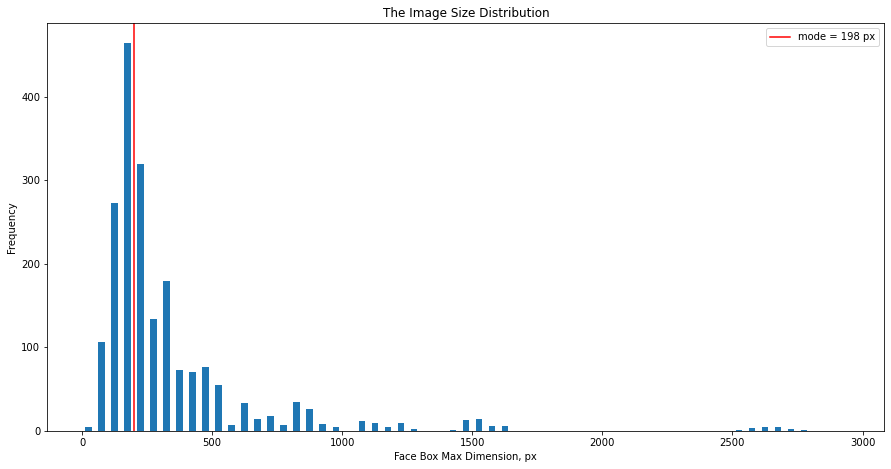

In [147]:
df, meta = loadData()
df, meta = preamble(df,meta)
max_box_dim = df['max_box_dim'].to_dask_array()
box_dim_mode = df['max_box_dim'].mode().compute()[0]
bins = np.arange(0,3000,50)
h, bins = da.histogram(max_box_dim,bins)
bincenter = (bins-25)[1:]
figimgsz = plt.figure(figsize=(15,7.5))
plt.bar(bincenter,h.compute(),width=25)
plt.axvline(box_dim_mode, color = 'red', label='mode = '+str(box_dim_mode)+' px')
plt.title('Image Size Distribution')
plt.xlabel('Face Box, Max Dimension, px')
plt.ylabel('Frequency')
plt.legend()

### Visualization of Distributed Mode Process

In the reduction chunk I suspect the data is reduced to the frequency of each number. Each worker doesn't know the frequencies calculated by the other workers. Thus a worker is given the task of collecting the results, summing them together and reducing it into one most frequently apparent value. 

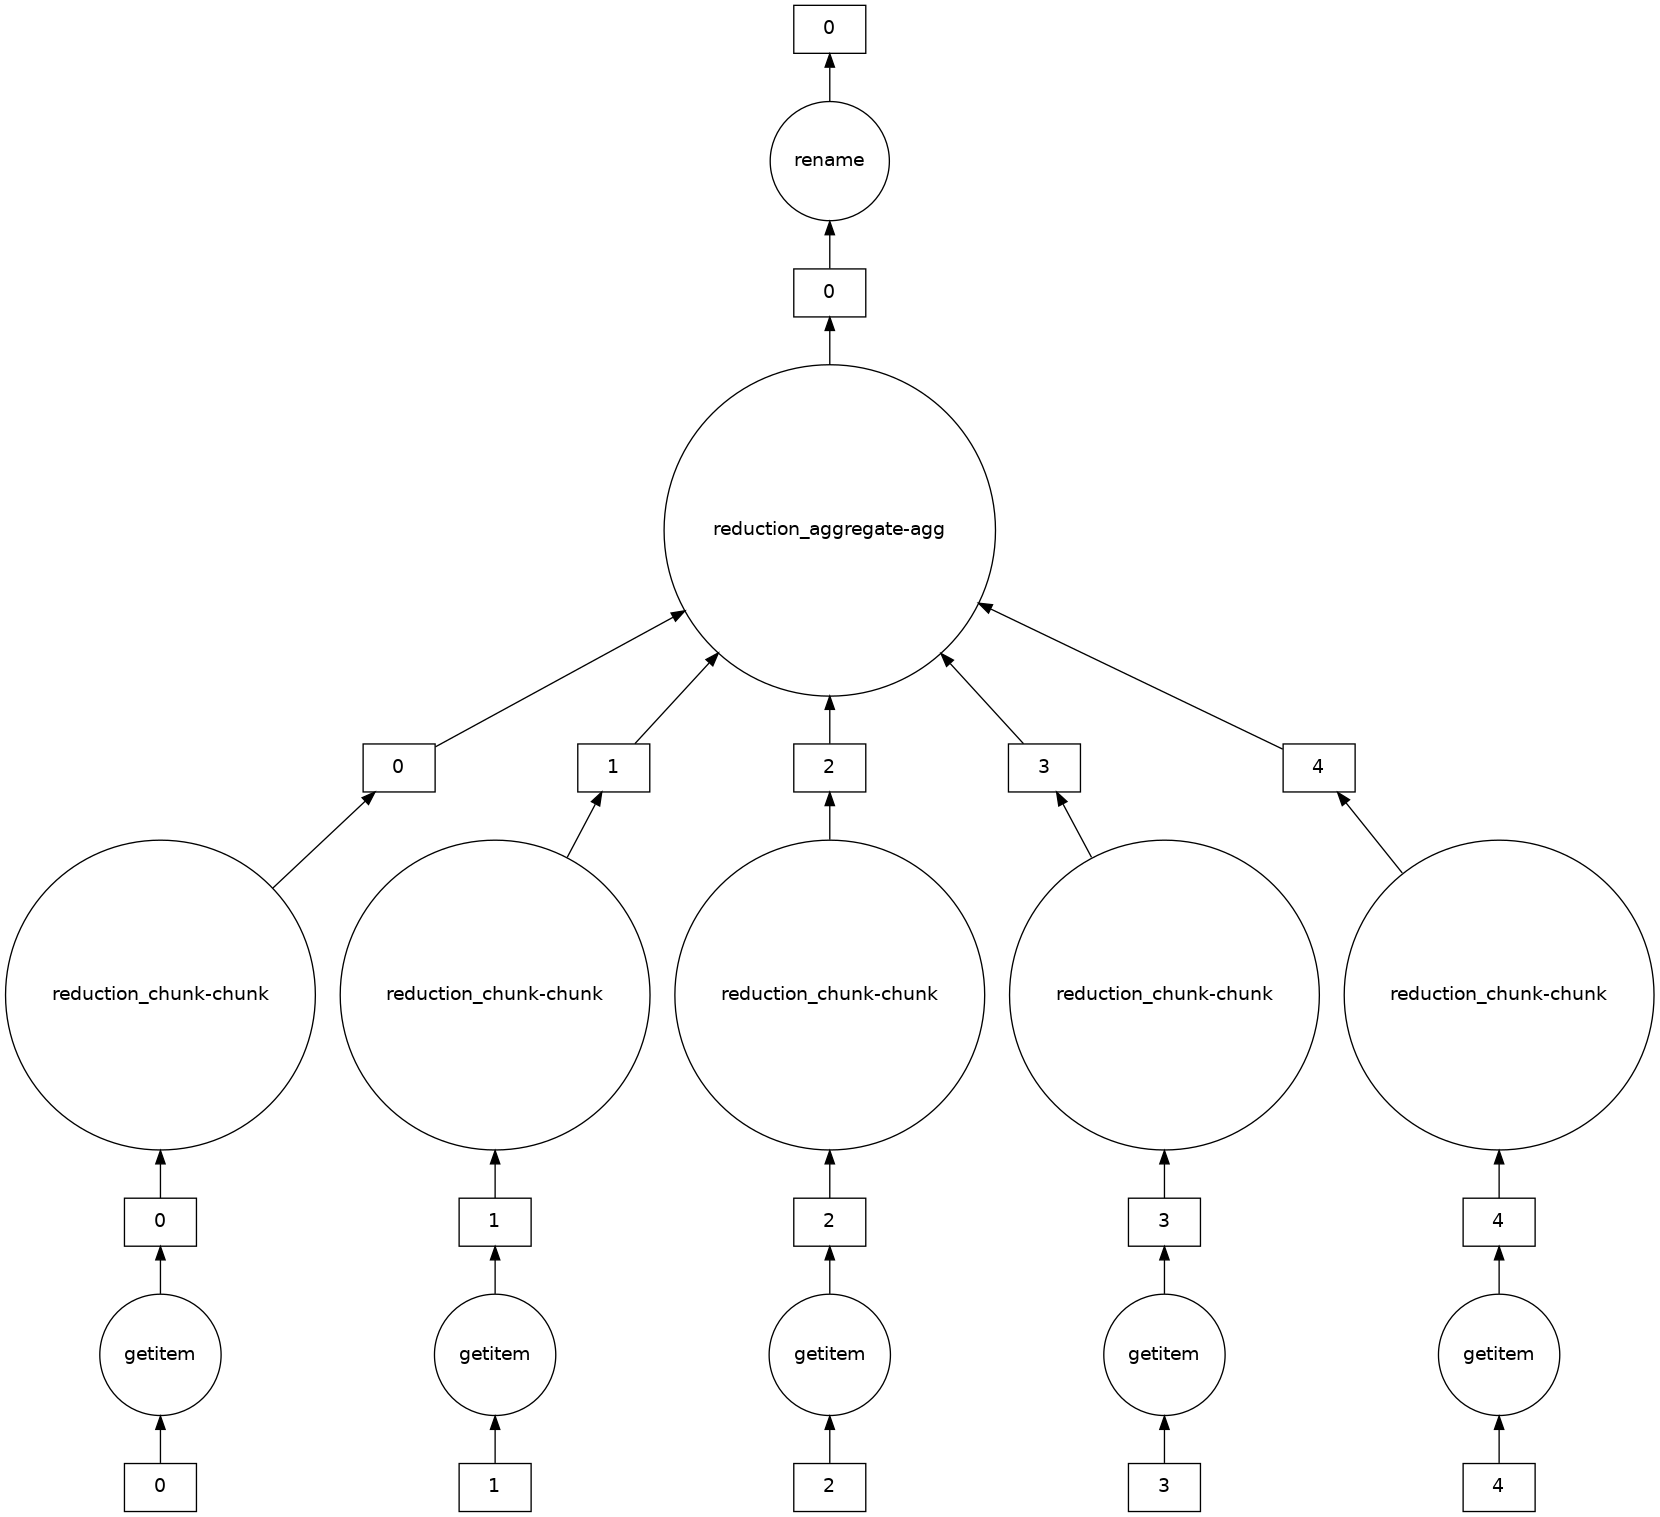

In [152]:
df = df.persist()
df = df.repartition(npartitions=5).persist()
box_dim_mode = df['max_box_dim'].mode()
box_dim_mode.visualize()

### Visualization of Distributed Histogram Process

In the histogram sum nodes I suspect the workers are summing up the frequencies in each bin. They don't know what frequencies the other workers have summed. The workers results have to be summed. Dask has decided to do this in two steps. Have two workers collect different results and sum them. Then have a final worker sum the result of these two. The partital sum seems to be imbalanced. One worker sums 4 sets of the results whilst another only has one. It is shown by increasing the number of partitions dask finds a better balance. 

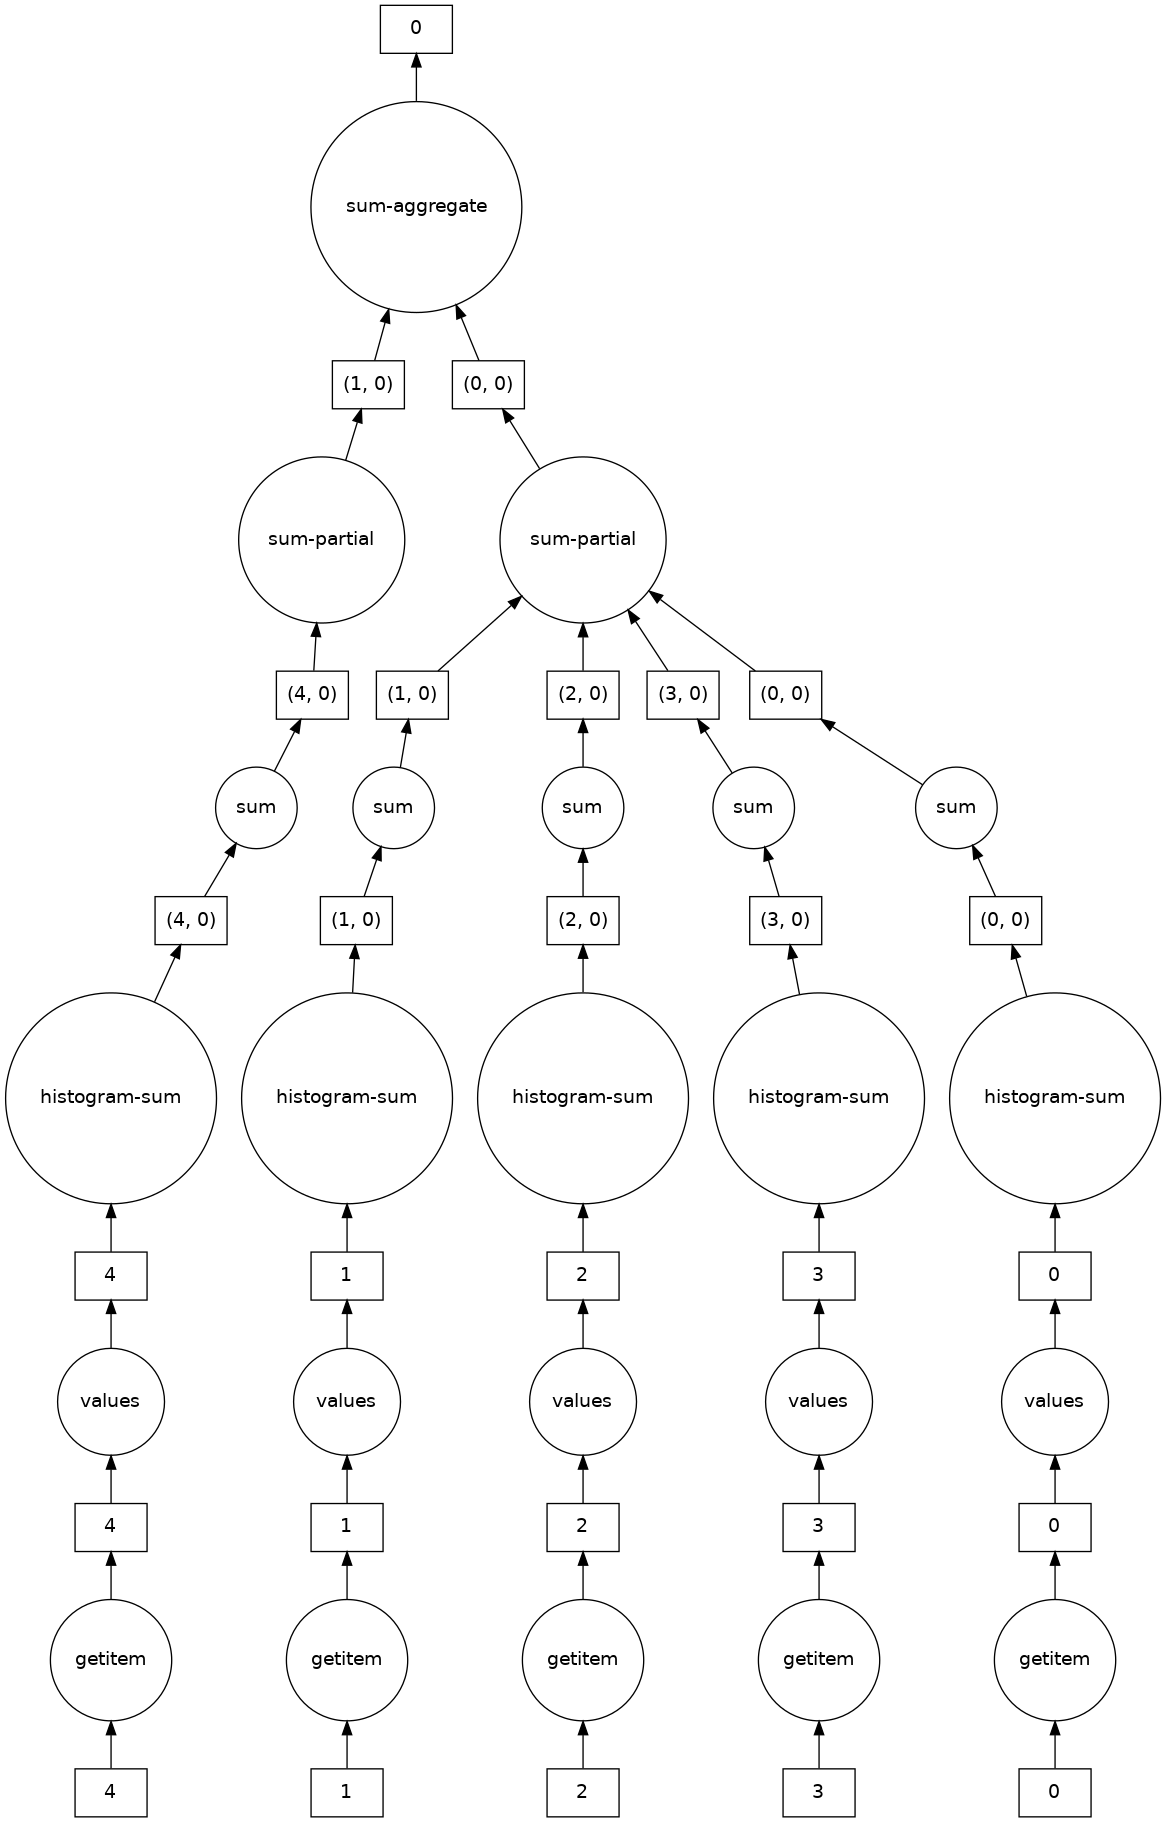

In [158]:
df, meta = loadData()
df, meta = preamble(df,meta)
df = df.repartition(5).persist()
max_box_dim = df['max_box_dim'].to_dask_array()
h, bins = da.histogram(max_box_dim,bins)
h.visualize()

### 8 partitions
It was strange that dask had one worker do 4 sums and another do 1. To investigate a little further I tried 8 partitions. With 8 partitions dask spread the partial sum more evenly.

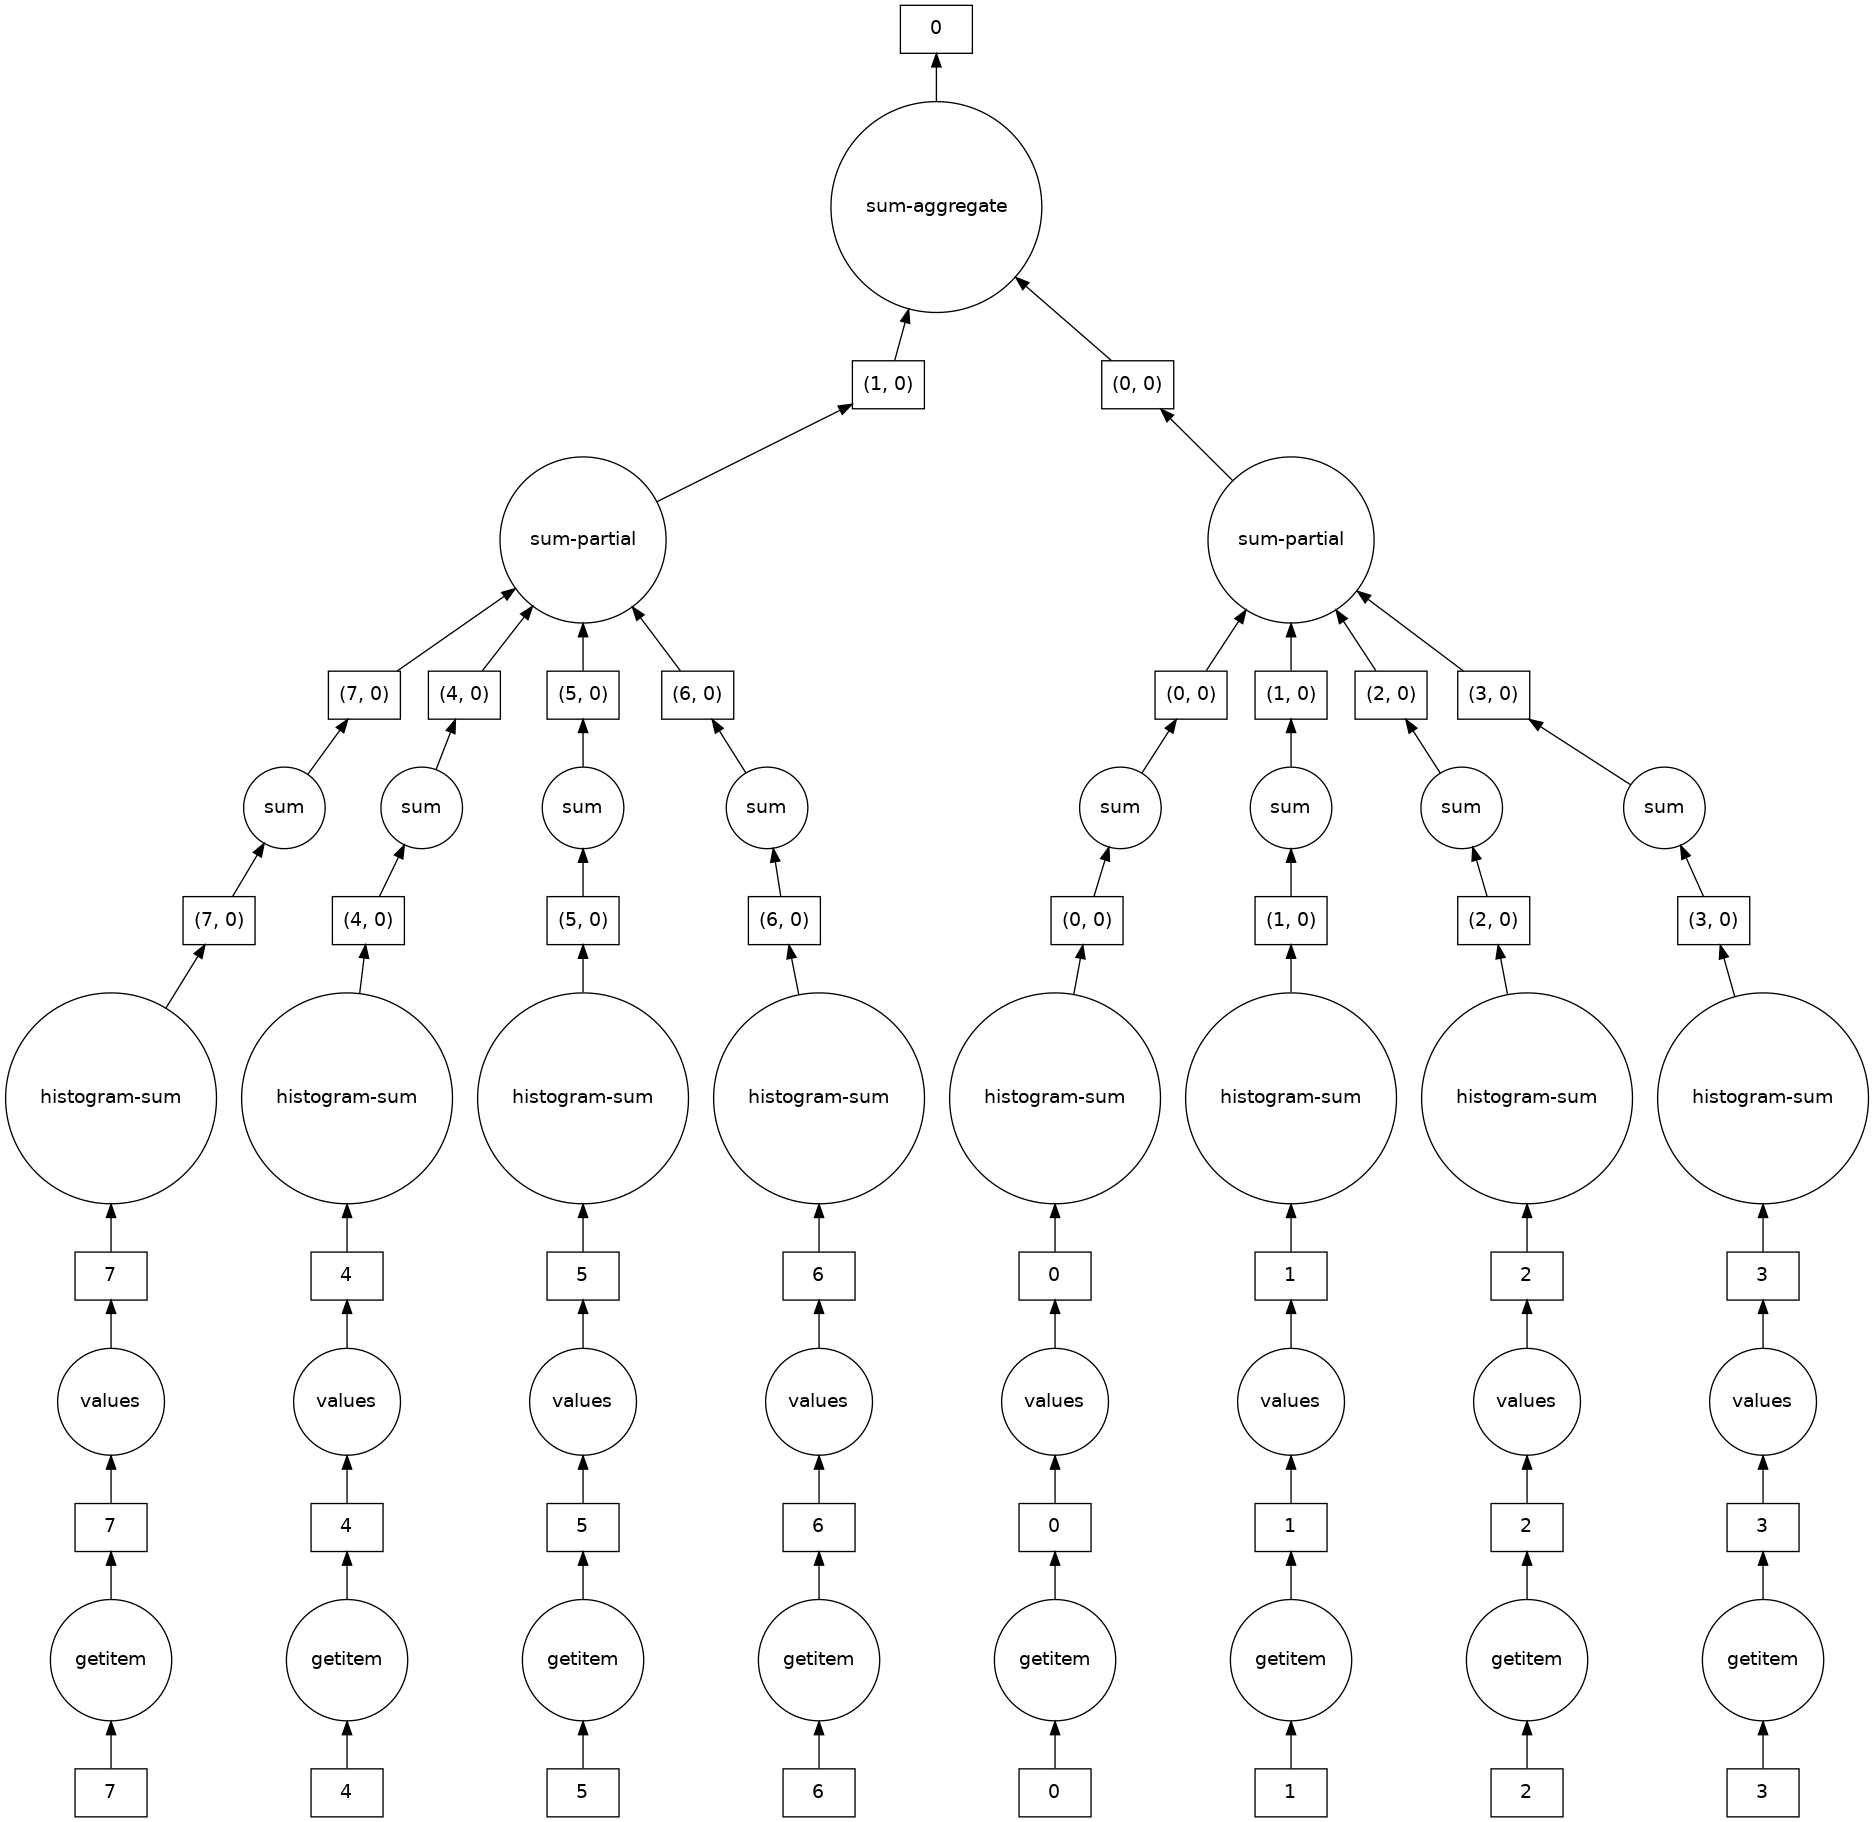

In [157]:
df, meta = loadData()
df, meta = preamble(df,meta)
df = df.repartition(8).persist()
max_box_dim = df['max_box_dim'].to_dask_array()
h, bins = da.histogram(max_box_dim,bins)
h.visualize()

The mode of the max box dimensions is:  198
This will be our default image width and height for the ML model


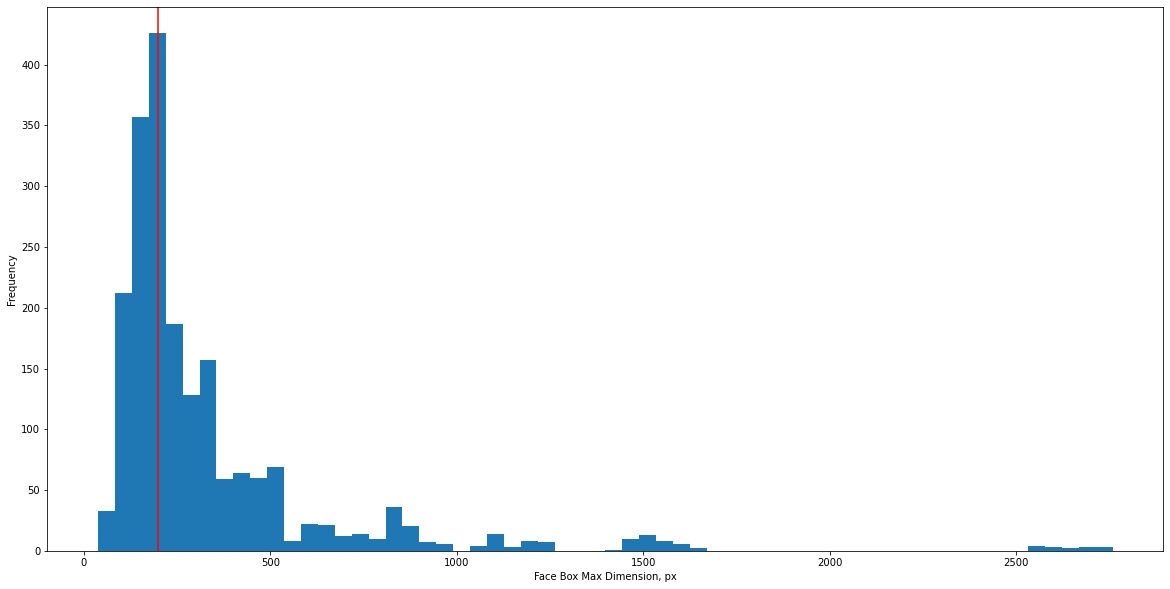

In [20]:

fig = plt.figure(figsize=(20,10))
plt.hist(df['max_box_dim'].compute(), bins = 60, log = False)
box_dim_mode = df['max_box_dim'].mode().compute()[0]
plt.axvline(box_dim_mode, color = 'red')
plt.xlabel('Face Box Max Dimension, px')
plt.ylabel('Frequency')
print('The mode of the max box dimensions is: ',box_dim_mode)
print('This will be our default image width and height for the ML model')

# Image Processing
The data in the dask data frame will be used to crop and resize the turtle images to 198x198. The turtle face will be extracted from each photo to create the Face samples. A random portions of each photo, the same size as the face portion, will be selected to create to noFace samples.

To accomplish this the face information of the data frame needs to be linked with it's corrosponding image. If I load all of the images into a dask array. It is impossable to know their order and how they match up with the dataframes information.

The first approach to overcome this is to go through each row of the dask dataframe and load the corrosponding image, manipulate it and then add it to a dask array for further processing. This works but adds an unecessary amount of reading time to the process.

The second approach is to load the images into the dataframe as a column. Then it is already there close to the face information. And can be used multiple times without the need to reload the images. This significantly increases the size of the datframe and so a small number of partitions can kill the workers.


# Getting the Face Images

The ML model will be trained to classify partial images of turtles into face and noace. The provided images of turtles will be processed to extract the turtles faces. Labels have been provided represent a box surrounding the turtles face in each image. The boxes are not square. The ML model needs all the images to be the same size. To overcome this the shorter side is made equal to the longer size and the image is cropped to the new box. 

The next code cell will do the following:
 - run a function getFace on each dask dataframe partition, which is a pandas dataframe
 (Each partition can be ran on a different core/thread)
    - run a function getFace2 on each row of the partition.
        - This function will load the image associated with the row
        - Crop the image to a square the box that is mostly taken up by the turtles face
        - Save the new image to a file. 

CPU times: user 212 ms, sys: 24.1 ms, total: 237 ms
Wall time: 557 ms


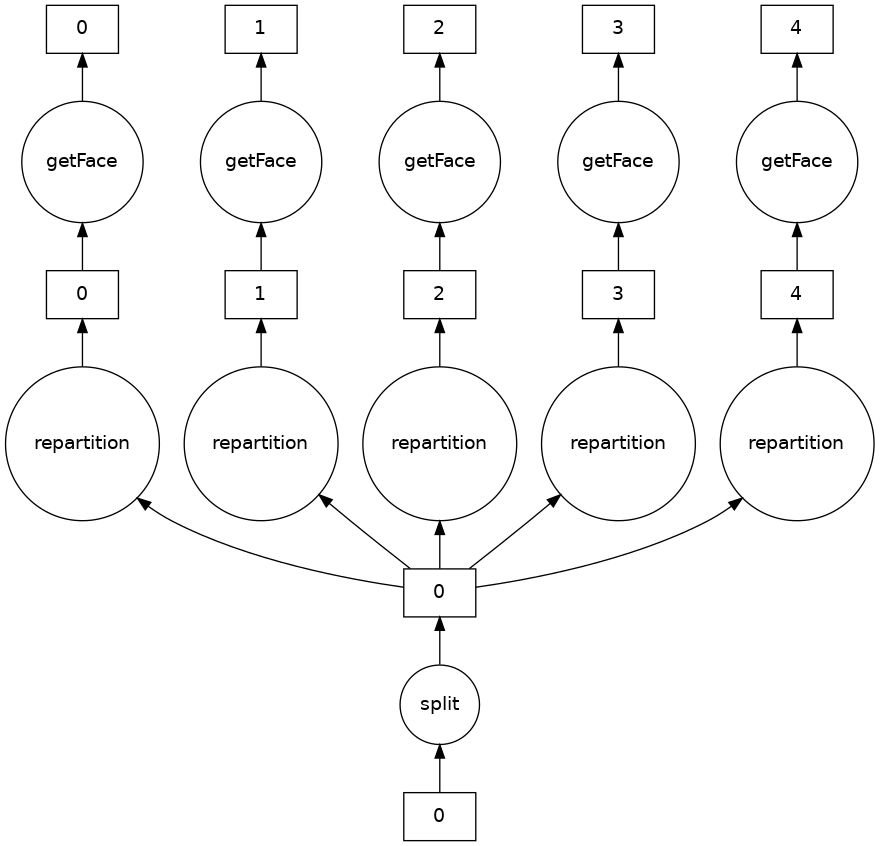

In [43]:
%%time
from skimage import util
def getFace(partition):
    def getFace2(image_info):
        im = io.imread(image_info['file_path'])
        im = im[:,:,:3]# remove fourth channel if it exists
        y = image_info['box_topleft_y']
        x = image_info['box_topleft_x']
        dim = {'box_width':image_info['box_width'],'box_height':image_info['box_height']}
        max_dim_key = max(dim, key = dim.get)
        max_dim = image_info['max_box_dim']
        dif = np.abs(image_info['box_width'] - image_info['box_height'])
        half_dif = int(dif/2)
        if max_dim_key == 'box_width':
            new_top = y-half_dif
            new_bottom = new_top + max_dim
            pad_width = 0
            if(new_top < 0):
                pad_width = -new_top
                new_top = 0
            if(new_bottom > image_info['image_height']):
                pad_width = new_bottom - image_info['image_height']
                new_bottom = image_info['image_height']
            
            im = np.pad(im, pad_width = [(pad_width,pad_width),(pad_width,pad_width),(0,0)], mode = 'reflect')
            face = im[ new_top : new_bottom, x : x+max_dim, :]
            del new_top, new_bottom, pad_width
            
        if max_dim_key == 'box_height':
            new_left = x-half_dif
            new_right = new_left + max_dim
            pad_width = 0
            if(new_left < 0):
                pad_width = -new_left
                new_left = 0
            if(new_left > image_info['image_width']):
                pad_width = new_left - image_info['image_width']
                new_left = image_info['image_width']
            im = np.pad(im, pad_width = [(pad_width,pad_width),(pad_width,pad_width),(0,0)], mode = 'reflect')
            face = im[ y : y+max_dim, new_left : new_right, :]
            del new_left, new_right, pad_width
        face = transform.resize(face,(198,198,3))
        face = util.img_as_ubyte(face)
        del im, y, x, dim, max_dim_key, max_dim, dif, half_dif
        
        path = Path(path_face,'face_'+image_info['face_number']+'.jpg')
        io.imsave(path,face)
        
        #return [face]
    partition['face_img'] = partition.apply(getFace2, axis = 1)
    #return partition

df, meta = loadData()
df, meta = preamble(df, meta, persist=True)
df = df.repartition(npartitions=5)
meta = pd.DataFrame({'none':[None]})
# meta['face_img'] = [np.zeros((198,198,3))]
facedf = df.map_partitions(getFace, meta = meta)
facedf.visualize()
# del df
# facedf

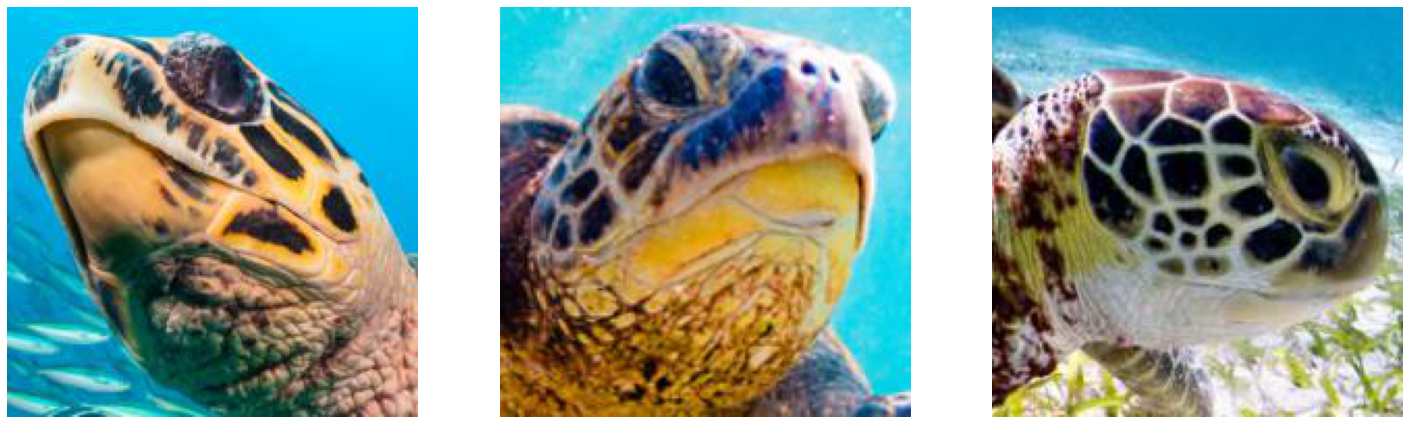

In [65]:
img1 = io.imread(Path(path_face,'face_10.jpg'))
img2 = io.imread(Path(path_face,'face_123.jpg'))
img3 = io.imread(Path(path_face,'face_45.jpg'))

figTf, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(25,25))
ax1.imshow(img1)
ax2.imshow(img2)
ax3.imshow(img3)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
a=1

# Getting the noface images

The ML model will be trained to classify partial images of turtles into face and no face. The provided images of turtles will be processed to extract sections of those images that do not contain a face. To do this the information in the dataframe of the face location is required.

The next code cell will do the following:
 - run a function getNoFace on each dask dataframe partition which is a pandas dataframe
 (Each partition can be ran on a different core/thread)
    - run a function getNoFace2 on each row of the partition.
        - This will load the image associated with the row
        - split it into four images, one on each side of the turtle face box, these images are called sides
        - Take the largest of these four sides and take a random chunck about the same size as the face box. This is the extracted noFace image. (This makes sure the no face images are as similar as possible to the face image, in terms of resolution and amount of the turtle visable)
        - Sometimes the largest side is smaller then the face box. In this case the largest random square is taken as the noFace Image.
        - The noFace image extraced is resized to 198 by 198 pixels. (This is the mode of the largest facebox dimension, and so most of the face images are limited to this ammount of imformation.)
        - The the new noFace image is then saved to a file.
 

## Training memory summary
many unmanaged memory warnings appear. 
after 2 training runs trim took about 0.5GB of ram off of each worker
all the dels in and before training have saved about 0.5GB of ram per worker. 


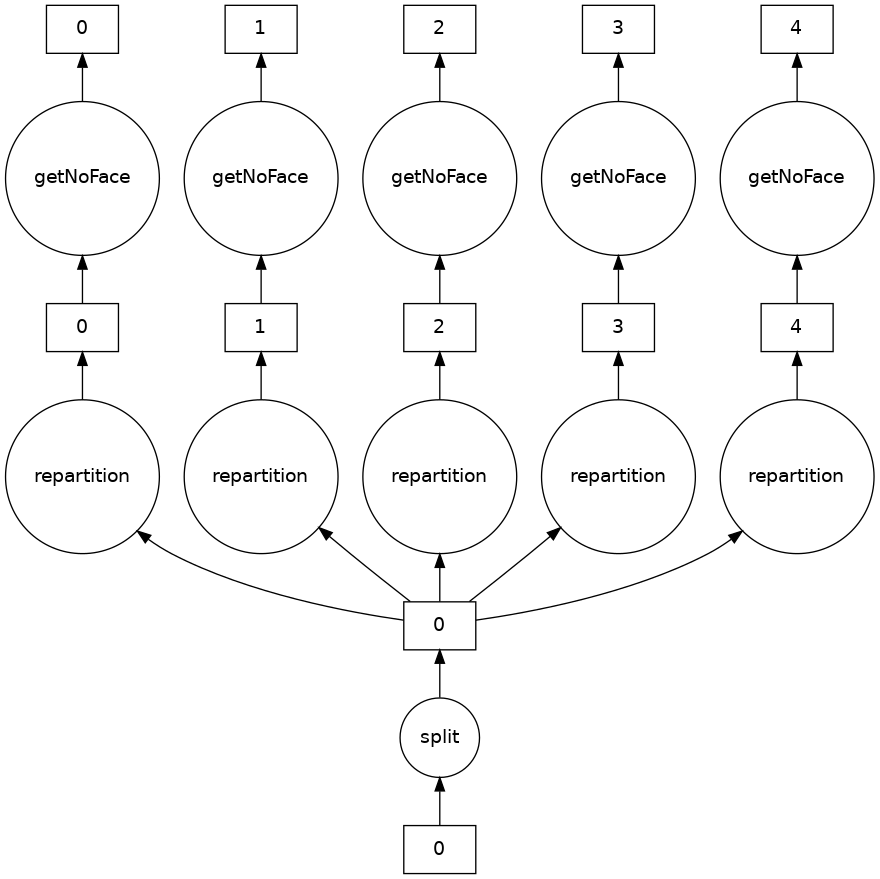

In [44]:
def getNoFace(partition):
    def getNoFace2(image_info):
        im = io.imread(image_info['file_path'])
        im = im[:,:,:3]# remove fourth channel if it exists
        im_left = im[:, 0:image_info['box_topleft_x'] ,:]
        im_right = im[:, image_info['box_bottomright_x']: ,:]
        im_top = im[0:image_info['box_topleft_y'],:,:]
        im_bottom = im[image_info['box_bottomright_y']:,:,:]
        del im
        var = locals()
        sizes ={'im_left':np.min(np.shape(im_left)[0:2]),'im_right':np.min(np.shape(im_right)[0:2]),'im_top':np.min(np.shape(im_top)[0:2]),'im_bottom':np.min(np.shape(im_bottom)[0:2])}
        max_side_key = max(sizes, key = sizes.get)
        rand_gen = np.random.default_rng(12345)
        max_box_dim = np.max([image_info['box_width'],image_info['box_height']])
        if sizes[max_side_key]<max_box_dim:
            side = var[max_side_key]
            dim = np.shape(side)[0:2]
            side_max_ind = np.argmax(dim)
            side_min_ind = not side_max_ind
            high = dim[side_max_ind] - dim[side_min_ind]
            along = rand_gen.integers(low = 0, high = high)
            if(side_max_ind == 0):
                noface = side[along:along+dim[side_min_ind],:,:]
            elif(side_max_ind == 1):
                noface= side[:, along:along+dim[side_min_ind] ,:]
            del side, dim, side_max_ind, side_min_ind, high, along
        else:
            side = var[max_side_key]
            side_width = np.shape(side)[1]
            side_height = np.shape(side)[0]
            rtlx = rand_gen.integers(low = 0, high = side_width - max_box_dim)
            rtly = rand_gen.integers(low = 0, high = side_height - max_box_dim)
            noface = side[rtly:rtly+max_box_dim, rtlx:rtlx+max_box_dim, :]
            del side, side_width, side_height, rtlx, rtly
        del var, sizes, max_side_key, rand_gen, max_box_dim
        noface = transform.resize(noface,(198,198,3)) 
        io.imsave(path,noface)
        #return [noface]
    partition['noface_img'] = partition.apply(getNoFace2, axis = 1)
    #return partition

df, meta = loadData()
df, meta = preamble(df,meta, persist=True)
df = df.repartition(npartitions=5)
meta = pd.DataFrame({'none':[None]})
# meta['noface_img'] = [np.zeros((198,198,3))]
nofacedf = df.map_partitions(getNoFace, meta = meta)
nofacedf.visualize()
#nofacedf.compute()
# del df
# nofacedf

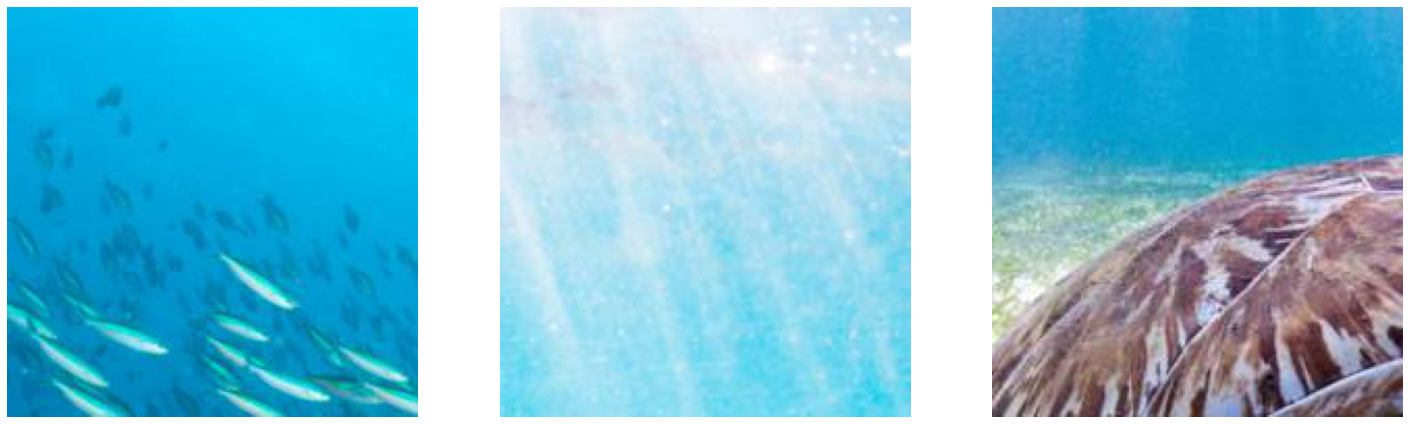

In [26]:
img1 = io.imread(Path(path_noface,'noface_10.jpg'))
img2 = io.imread(Path(path_noface,'noface_123.jpg'))
img3 = io.imread(Path(path_noface,'noface_45.jpg'))

figTf, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(25,25))
ax1.imshow(img1)
ax2.imshow(img2)
ax3.imshow(img3)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
a=1

# Partition/Chunk Tests

The way in which the data is chunked is important for performance.

- Balanced Chunks: The number of chunks need to be distributed evenly among the workers. If there is an imbalance then at the end of every process the remainder need to be processed by one worker. This can significantly affect run times.

- Ram Limit: If the memory size of the chunks approaces the size of the workers ram this can significantly reduce the procesing time. 

The various functions we have outlined will be tested for the ideal chunk size. To do this the data will be rechunked, persisted and then placed into the function. The run times will be measured for the various chunk sizes.

In [39]:
client.restart()

<Client: 'tcp://172.21.0.2:8786' processes=0 threads=0, memory=0 B>

### Preamble Partition Test

In [40]:
def partitionTest(fun,partitions,itterations,verbose=False):
    times = np.empty(len(partitions))
    std = np.empty(len(partitions))
    df, meta = loadData()
    count = 0
    for npart in partitions:
        count+=1
        if (verbose): print('Testing',npart,'partitions')
        times2 = []
        df = df.repartition(npartitions=npart).persist()
        wait(df)
        for j in itterations:
            t1 = time.perf_counter()
            fun(df,meta)
            t2 = time.perf_counter()
            times2.append(t2-t1)
        times[count-1] = np.mean(times2)
        std[count-1] = np.std(times2)
    times = times*1000
    std = std*1000
    return times, std

In [63]:
size = [2000/p for p in partitions]
partitions

[6,
 12,
 18,
 24,
 30,
 36,
 42,
 48,
 54,
 60,
 66,
 72,
 78,
 84,
 90,
 96,
 102,
 108,
 114,
 120]

In [41]:
nim = 2000
partitions = [6*i for i in range(1,21)]
part_size = [nim/p for p in partitions]
it = 20
itterations = range(it)
workers = client.scheduler_info()['workers'].keys()
preamble_perf = pd.DataFrame({'partitions':np.array(partitions)})
for i in range(1):#worker in workers:
    nw = len(client.scheduler_info()['workers'].keys())
    print('Testing',nw,'workers')
    times, std = partitionTest(preamble,partitions,itterations)
    preamble_perf['times_'+str(nw)+'w'] = times
    preamble_perf['std_'+str(nw)+'w'] = std
    if nw == 1: break
    #print('retireing a worker')
    #client.retire_workers(workers=[worker])
     
preamble_perf

Testing 2 workers


,partitions,times_2w,std_2w
0,6,58.235193,2.282984
1,12,57.908243,1.616757
2,18,58.499727,2.455001
3,24,71.933975,58.970819
4,30,57.545572,2.186405
5,36,57.749106,2.653349
6,42,57.189464,1.476978
7,48,58.424422,1.425800
8,54,59.740163,5.205105
9,60,58.055107,0.966206


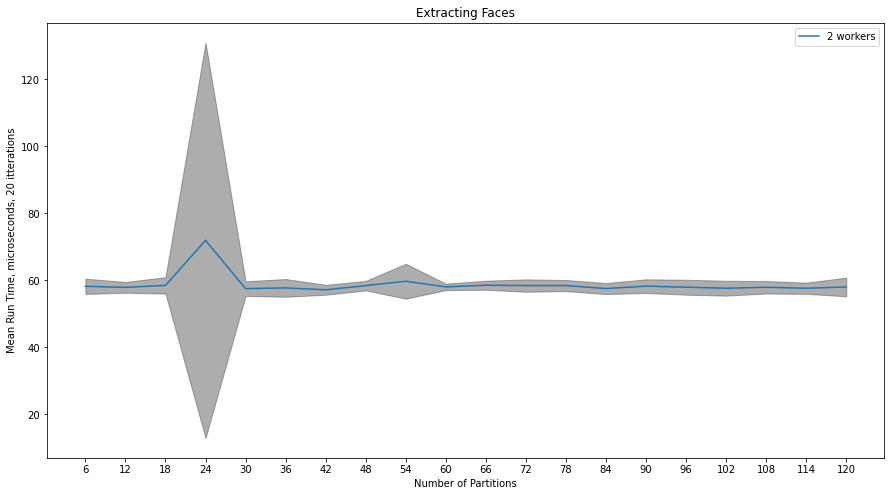

In [42]:
figPrePerf = plt.figure(figsize=(15,8))
for i in np.arange(2,1,-1):
    times = preamble_perf['times_'+str(i)+'w']
    plt.plot(partitions, times,label=str(i)+' workers')
    if i == 1: plt.fill_between(partitions,times+std,times-std, label='Standard Deviation', color=(0.2,0.2,0.2,0.4))
    else: plt.fill_between(partitions,times+std,times-std, color=(0.2,0.2,0.2,0.4))
plt.xticks(ticks=partitions)
plt.xlabel('Number of Partitions')
plt.ylabel('Mean Run Time, microseconds, '+str(it)+' itterations')
plt.title('Preamble Partition Test')
plt.legend()

### Discussion on the Preamble Partition Test Results
With 6 partitions each worker only needs to do one task. It would be expected that this would be the fastest situation because there is no overhead from switching tasks. Also the data comefortable fits into ram and so that is not and issue. Instead we see that the run time is in gerneral the largest and most unstable with 6 partitions. It begins to stabalise at .... After this the run time remains

how does the number of workers change things?
The run time is 

# Face Extraction Partition Test

In [47]:
def partestimg(df,partitions,itterations):
    times = np.empty(len(partitions))
    std = np.empty(len(partitions))
    count = 0
    for part in partitions:
        print('npartition being tested: ',part)
        count+=1
        df = df.repartition(npartitions=part)
        time2 = []
        for i in itterations:
            t1 = time.time()
            df2 = df.persist()
            wait(df2)
            t2 = time.time()
            time2.append(t2-t1)
        times[count-1] = np.mean(time2)
        std[count-1] = np.std(time2)
        print('Test done')
    return times, std

In [48]:
itterations = range(1)
workers = client.scheduler_info()['workers'].keys()
exFperf = pd.DataFrame({'partitions':np.array(partitions)})
for i in range(1):##worker in workers:
    nw = len(client.scheduler_info()['workers'].keys())
    
    times, std = partestimg(facedf,partitions,itterations)
    exFperf['times_'+str(nw)+'w'] = times
    exFperf['std_'+str(nw)+'w'] = std
#     print('retireing',nw)
#     client.retire_workers(workers=[worker])
#     print('retired')
exFperf

retireing 2
retired
npartition being tested:  6
Test done
npartition being tested:  12
Test done
npartition being tested:  18
Test done
npartition being tested:  24
Test done
npartition being tested:  30
Test done
npartition being tested:  36
Test done
npartition being tested:  42
Test done
npartition being tested:  48
Test done
npartition being tested:  54
Test done
npartition being tested:  60
Test done
npartition being tested:  66
Test done
npartition being tested:  72
Test done
npartition being tested:  78
Test done
npartition being tested:  84
Test done
npartition being tested:  90
Test done
npartition being tested:  96
Test done
npartition being tested:  102
Test done
npartition being tested:  108
Test done
npartition being tested:  114
Test done
npartition being tested:  120
Test done


,partitions,times_2w,std_2w
0,6,487.697204,0.0
1,12,0.145053,0.0
2,18,0.131323,0.0
3,24,0.147885,0.0
4,30,0.195981,0.0
5,36,0.248224,0.0
6,42,0.261998,0.0
7,48,0.292619,0.0
8,54,0.337949,0.0
9,60,0.336809,0.0


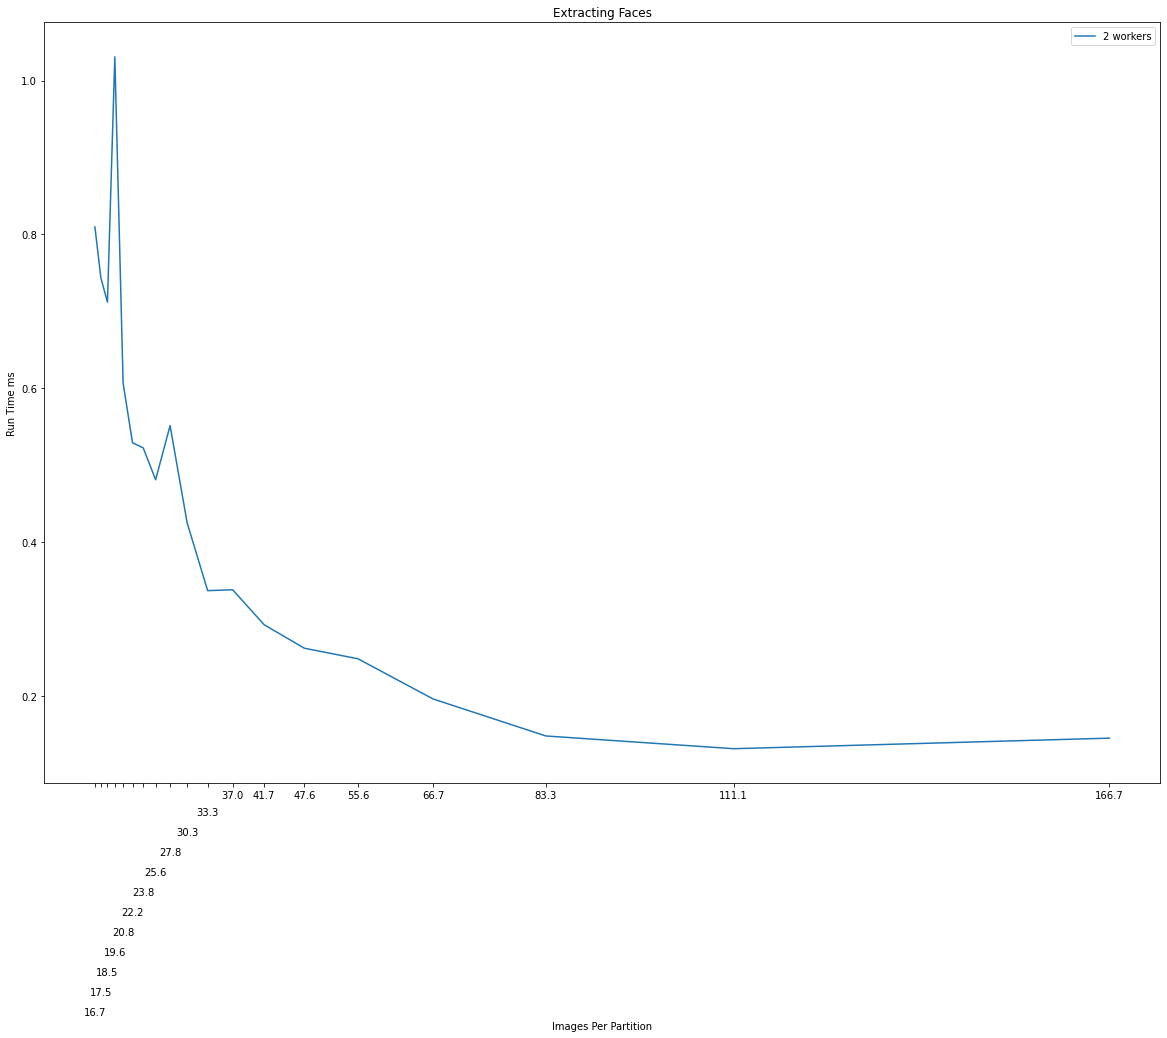

In [82]:
partitions = [6*i for i in range(1,21)]
part_size = [2000/p for p in partitions]
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(20,14))
for i in np.arange(2,3):
    times = exFperf['times_'+str(i)+'w']
    ax.plot(part_size[1:], times[1:],label=str(i)+' workers')
    #if i == 1: plt.fill_between(partitions,times+std,times-std, label='Standard Deviation', color=(0.9,0.2,0.2,0.7))
    #else: plt.fill_between(partitions,times+std,times-std, color=(0.9,0.2,0.2,0.7))
ax.set_xticks(part_size[1:])
pad = 0
for tick in ax.xaxis.get_major_ticks()[8:]:#[1::2]:
    pad = pad + 20
    tick.set_pad(pad)
#ax.set_xscale('log')
ax.set_xlabel('Images Per Partition')
ax.set_ylabel('Run Time ms')
ax.set_title('Extracting Faces')
ax.legend()


## noface Extraction Partition Test

In [ ]:
itterations = range(1)
workers = client.scheduler_info()['workers'].keys()
exFperf = pd.DataFrame({'partitions':np.array(partitions)})
for i in range(1):##worker in workers:
    nw = len(client.scheduler_info()['workers'].keys())
    
    times, std = partestimg(nofacedf,partitions,itterations)
    exFperf['times_'+str(nw)+'w'] = times
    exFperf['std_'+str(nw)+'w'] = std
#     print('retireing',nw)
#     client.retire_workers(workers=[worker])
#     print('retired')
exFperf

In [ ]:
partitions = [6*i for i in range(1,21)]
part_size = [2000/p for p in partitions]
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(20,14))
for i in np.arange(2,3):
    times = exFperf['times_'+str(i)+'w']
    ax.plot(part_size[1:], times[1:],label=str(i)+' workers')
    #if i == 1: plt.fill_between(partitions,times+std,times-std, label='Standard Deviation', color=(0.9,0.2,0.2,0.7))
    #else: plt.fill_between(partitions,times+std,times-std, color=(0.9,0.2,0.2,0.7))
ax.set_xticks(part_size[1:])
pad = 0
for tick in ax.xaxis.get_major_ticks()[8:]:#[1::2]:
    pad = pad + 20
    tick.set_pad(pad)
#ax.set_xscale('log')
ax.set_xlabel('Images Per Partition')
ax.set_ylabel('Run Time ms')
ax.set_title('Extracting Faces')
ax.legend()

Text(0.5, 1.0, 'Extracting Faces')

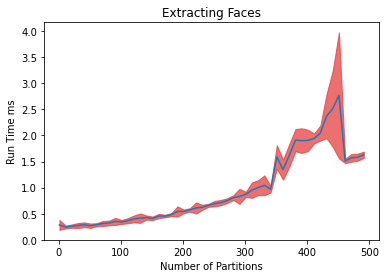

In [12]:
#timesall = np.concatenate(times,times2/1000)
#stdall = np.concatenate(std,std2/1000)
#times = times * 10**5
#std = std *10**5
plt.plot(partitions, times)
plt.fill_between(partitions,times+std,times-std, label='Standard Deviation', color=(0.9,0.2,0.2,0.7))
plt.xlabel('Number of Partitions')
plt.ylabel('Run Time ms')
plt.title('Extracting Faces')